## Data

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DIMS = 20
SAMPLES = 12000

In [3]:
X_first_half = torch.rand((SAMPLES, int(DIMS/2))) * 100 - 22
X_second_half = torch.randn((SAMPLES, int(DIMS/2))) * 32 + 15

X = torch.cat([X_first_half, X_second_half], dim=1)
X.shape

torch.Size([12000, 20])

In [4]:
w = torch.rand((DIMS,)) * 3 - 2
w

tensor([-0.9319, -0.6892,  0.1635, -1.1829,  0.9663, -1.7164, -0.1212, -0.6277,
        -1.7636, -1.5607, -0.6541,  0.4948, -1.0409, -0.7226, -1.8381, -0.3688,
        -1.5977, -0.5925, -1.9361, -0.9424])

In [5]:
X_transformed = torch.matmul(X, w)

Y = (X_transformed ** 2 + X_transformed * torch.cos(X_transformed) + torch.randn(len(X_transformed)) * 10).unsqueeze(1)

X.shape, Y.shape

(torch.Size([12000, 20]), torch.Size([12000, 1]))

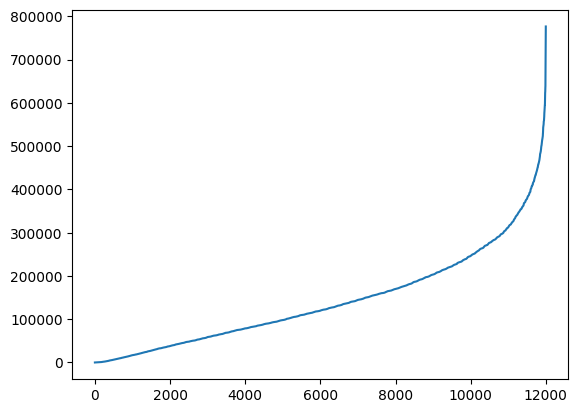

In [6]:
plt.plot(range(len(Y)), torch.sort(Y.squeeze()).values)

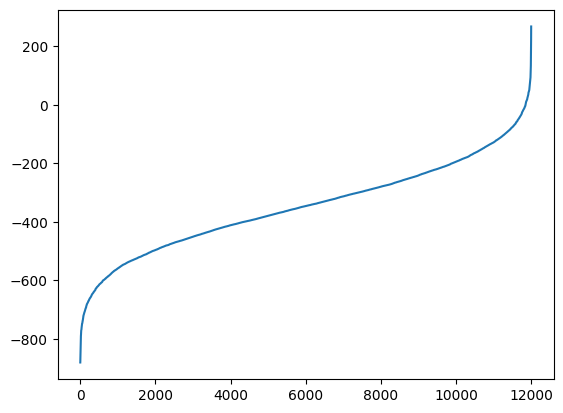

In [7]:
plt.plot(range(len(X_transformed)), torch.sort(X_transformed).values)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=2000)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([10000, 20]),
 torch.Size([2000, 20]),
 torch.Size([10000, 1]),
 torch.Size([2000, 1]))

## ANN

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
from torch import nn
from torchinfo import summary

class SimpleNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=20, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )
    
    def forward(self, x):
        return self.layers(x)

summary(
    model=SimpleNN(),
    input_size=(32, 20),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
SimpleNN                                 [32, 20]             [32, 1]              --                   True
├─Sequential: 1-1                        [32, 20]             [32, 1]              --                   True
│    └─Linear: 2-1                       [32, 20]             [32, 64]             1,344                True
│    └─ReLU: 2-2                         [32, 64]             [32, 64]             --                   --
│    └─Linear: 2-3                       [32, 64]             [32, 64]             4,160                True
│    └─ReLU: 2-4                         [32, 64]             [32, 64]             --                   --
│    └─Linear: 2-5                       [32, 64]             [32, 64]             4,160                True
│    └─ReLU: 2-6                         [32, 64]             [32, 64]             --                   --
│    └─Linear: 2-7  

In [11]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, batch_size=32, shuffle=True), make_dataloader(X_val, Y_val, batch_size=32)

In [21]:
model = SimpleNN().to(device)

In [22]:
from scripts.metrics import NegMeanSquaredError

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters())
metric = NegMeanSquaredError()

In [23]:
from scripts.train import train_model

history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    device=device
)

Training model for 500 epochs. Early stopping not enabled.
Epoch: 1 => Train loss: 14979814400.000000, Train score: -14979814400.000000, Val loss: 3679132672.000000, Val score: -3679132672.000000
Epoch: 2 => Train loss: 2351460352.000000, Train score: -2351460352.000000, Val loss: 1777137152.000000, Val score: -1777137152.000000
Epoch: 3 => Train loss: 1671182464.000000, Train score: -1671182464.000000, Val loss: 1654594944.000000, Val score: -1654594944.000000
Epoch: 4 => Train loss: 1636720768.000000, Train score: -1636720768.000000, Val loss: 1636810112.000000, Val score: -1636810112.000000
Epoch: 5 => Train loss: 1615432448.000000, Train score: -1615432448.000000, Val loss: 1619119104.000000, Val score: -1619119104.000000
Epoch: 6 => Train loss: 1607992576.000000, Train score: -1607992576.000000, Val loss: 1633666688.000000, Val score: -1633666688.000000
Epoch: 7 => Train loss: 1593370240.000000, Train score: -1593370240.000000, Val loss: 1601100160.000000, Val score: -1601100160.0

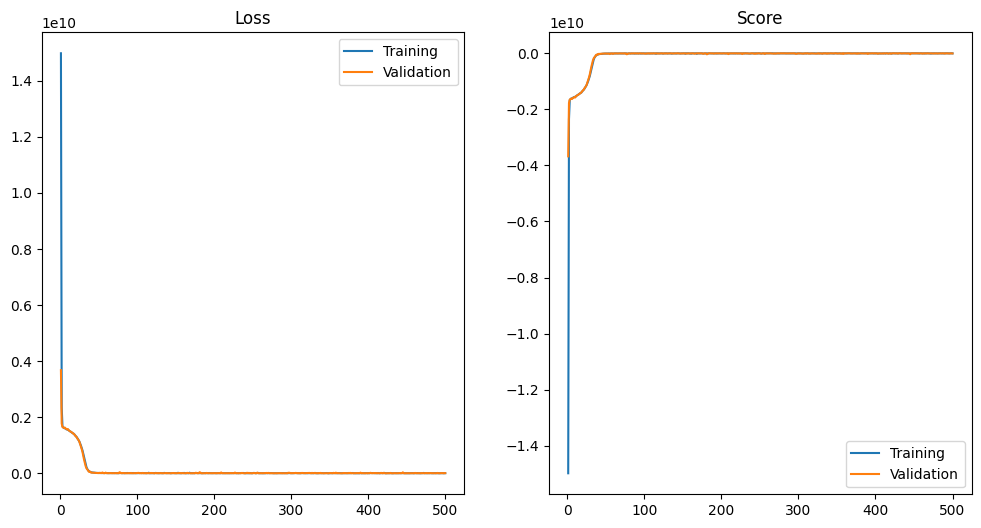

In [24]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [28]:
from scripts.test import predict

preds_train, preds_val = predict(model, X_train, device), predict(model, X_val, device)
score_train, score_val = metric(preds_train.cpu(), Y_train), metric(preds_val.cpu(), Y_val)
score_train, score_val

(tensor(-7283359.), tensor(-9014773.))

## SVM

In [16]:
from sklearn.svm import SVR

In [19]:
from sklearn.metrics import mean_squared_error

In [35]:
model = SVR(C=1e5)

In [36]:
model.fit(X_train, Y_train.squeeze())

SVR(C=100000.0)

In [37]:
preds_train, preds_val = model.predict(X_train), model.predict(X_val)
score_train, score_val = mean_squared_error(Y_train, preds_train), mean_squared_error(Y_val, preds_val)
score_train, score_val

(41815900.890522465, 105353703.46823044)